In this practice, we will exercise handling molecules with RDKit which is the python package for digitization and process molecules.

First, import the RDKit.

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem

import numpy as np

Most of chemistry databases store molecular structures with SMILES (Simplified Molecular Input Line Entry System) format. Let's load the SMILES of aspirin molecule. We can find a SMILES of a certain molecule in a Wikipedia. 

In [2]:
smi = 'O=C(C)Oc1ccccc1C(=O)O'

Then, convert this SMILES to 'mol' format. We can obtain molecular features and properties by utilizing this mol format as an input to functions of RDKit.

In [3]:
mol = Chem.MolFromSmiles(smi)

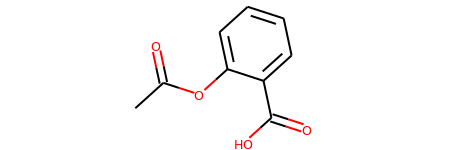

In [4]:
mol

In [5]:
mol.GetNumAtoms()

13

This molecules consists of total 13 non-hydrogen atoms. We can include hydrogen atoms with the function 'AddHs'.

In [6]:
mol_with_hydrogens = AllChem.AddHs(mol)

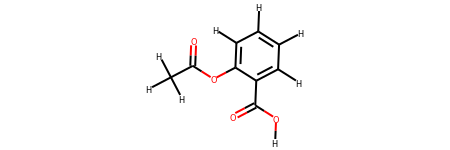

In [7]:
mol_with_hydrogens

We can compute some molecular properties with built-in functions. 
For example, total polar surface area (TPSA) of this molecule is

In [8]:
Chem.rdMolDescriptors.CalcTPSA(mol)

63.60000000000001

We can find what molecular properties can be computed in the document of RDKit. 

To utilize molecular structures with graph representation, we need to obtain atomic features and adjacency matrices. 
The adjacency matrix of Aspirin is

In [9]:
Chem.rdmolops.GetAdjacencyMatrix(mol)

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=int32)

With this information, we can uniquely represent molecules along with atomic features. 
For this purpose, we have to obtain 'atomic symbol', 'degree of bondings', 'total number of hydrogens', 'implicit valence number' and 'aromaticity' of every atom. 
Let's look this features step by step

In [10]:
atom = mol.GetAtoms()[0]

In [11]:
atom.GetSymbol()

'O'

In [12]:
atom.GetDegree()

1

In [13]:
atom.GetTotalNumHs()

0

In [14]:
atom.GetImplicitValence()

0

In [15]:
atom.GetIsAromatic()

False

Now, we can build collection of atomic features by one-hot encoding and representing them into a matrix format.
Let's define some functions.

In [16]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x==s, allowable_set))

In [17]:
def atom_feature(atom):
    symbol_set = ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br', 
                  'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B', 
                  'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                  'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']
    degree_set = [0,1,2,3,4,5]
    num_hydrogens_set = [0,1,2,3,4]
    valency_set = [0,1,2,3,4,5]
    return np.array(one_of_k_encoding(atom.GetSymbol(), symbol_set) + 
                    one_of_k_encoding(atom.GetDegree(), degree_set) + 
                    one_of_k_encoding(atom.GetTotalNumHs(), num_hydrogens_set) + 
                    one_of_k_encoding(atom.GetImplicitValence(), valency_set) +
                    [atom.GetIsAromatic()]).astype('float')

In [18]:
atom_feature(atom)

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0.])

In [19]:
atom_feature(atom).shape

(58,)

By combining those functions, we can now compute atomic features and adjacency matrix of molecules. 

In [20]:
def graph_representation(mol, max_atoms):
    adj = np.zeros((max_atoms, max_atoms))
    atom_features = np.zeros((max_atoms, 58))
    num_atoms = mol.GetNumAtoms()

    adj[0:num_atoms, 0:num_atoms] = Chem.rdmolops.GetAdjacencyMatrix(mol) + np.eye(num_atoms)
        
    features_tmp = []
    for atom in mol.GetAtoms():
        features_tmp.append(atom_feature(atom))
    atom_features[0:num_atoms, 0:58] = np.array(features_tmp)
    return adj, atom_features

In [21]:
adj_, features_ = graph_representation(mol, 20)

In [22]:
adj_

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [23]:
features_

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We successfully obtain the graph representation of Aspirin for an input of our neural network models. 
We would like to recommend students to do homeworks: utilize 'tf.data' module and rdkits to implement an input pipeline of molecular structures. 

- Get some list of SMILES
- Build a map-function that converts a SMILES to a graph representation.
- configure the dataset.

This input pipeline will be used for neural networks for molecules, such as graph convolution networks, in the upcoming practices.